In [1]:
import numpy as np
from ucimlrepo import fetch_ucirepo 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2
import miceforest as mf
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer
from lightgbm import LGBMRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_diabetes
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
data = pd.read_csv("dataset-4.csv") # importuję plik z danymi

In [3]:
data.select_dtypes("object").head() # sprawdzam czy występują dane tekstowe lub mieszane

,Date
0,2013-06-30
1,2013-06-30
2,2013-06-30
3,2013-06-30
4,2013-06-30


In [4]:
data.drop(["Date", "LDAPS_PPT1", "LDAPS_PPT2", "LDAPS_PPT3", "LDAPS_PPT4"], axis=1, inplace=True) 

In [5]:
data = data.dropna()

In [6]:
data

,station,Present_Tmax,Present_Tmin,LDAPS_RHmin,LDAPS_RHmax,LDAPS_Tmax_lapse,LDAPS_Tmin_lapse,LDAPS_WS,LDAPS_LH,LDAPS_CC1,LDAPS_CC2,LDAPS_CC3,LDAPS_CC4,lat,lon,DEM,Slope,Solar radiation,Next_Tmax,Next_Tmin
0,1.0,28.7,21.4,58.255688,91.116364,28.074101,23.006936,6.818887,69.451805,0.233947,0.203896,1.616969e-01,0.130928,37.6046,126.991,212.3350,2.7850,5992.895996,29.1,21.2
1,2.0,31.9,21.6,52.263397,90.604721,29.850689,24.035009,5.691890,51.937448,0.225508,0.251771,1.594441e-01,0.127727,37.6046,127.032,44.7624,0.5141,5869.312500,30.5,22.5
2,3.0,31.6,23.3,48.690479,83.973587,30.091292,24.565633,6.138224,20.573050,0.209344,0.257469,2.040915e-01,0.142125,37.5776,127.058,33.3068,0.2661,5863.555664,31.1,23.9
3,4.0,32.0,23.4,58.239788,96.483688,29.704629,23.326177,5.650050,65.727144,0.216372,0.226002,1.611574e-01,0.134249,37.6450,127.022,45.7160,2.5348,5856.964844,31.7,24.3
4,5.0,31.4,21.9,56.174095,90.155128,29.113934,23.486480,5.735004,107.965535,0.151407,0.249995,1.788925e-01,0.170021,37.5507,127.135,35.0380,0.5055,5859.552246,31.2,22.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7745,21.0,23.1,17.8,24.688997,78.261383,27.812697,18.303014,6.603253,9.614074,0.052902,0.030169,0.000000e+00,0.004380,37.5507,127.040,26.2980,0.5721,4456.024414,27.6,17.7
7746,22.0,22.5,17.4,30.094858,83.690018,26.704905,17.814038,5.768083,82.146707,0.066461,0.024518,5.850000e-07,0.017678,37.5102,127.086,21.9668,0.1332,4441.803711,28.0,17.1
7747,23.0,23.3,17.1,26.741310,78.869858,26.352081,18.775678,6.148918,72.058294,0.030034,0.081035,0.000000e+00,0.000000,37.5372,126.891,15.5876,0.1554,4443.313965,28.3,18.1
7748,24.0,23.3,17.7,24.040634,77.294975,27.010193,18.733519,6.542819,47.241457,0.035874,0.074962,0.000000e+00,0.000000,37.5237,126.909,17.2956,0.2223,4438.373535,28.6,18.8


In [7]:
data.drop(["station"], axis=1, inplace=True) 

In [8]:
# Wprowadzenie braków MNAR:
# 1. Braki w 'Present_Tmax' częściej występują dla wartości > 35
data.loc[data['Present_Tmax'] > 35, 'Present_Tmax'] = np.nan
data.loc[data['Present_Tmin'] < 15, 'Present_Tmin'] = np.nan
data.loc[data['DEM'] < 50, 'DEM'] = np.nan


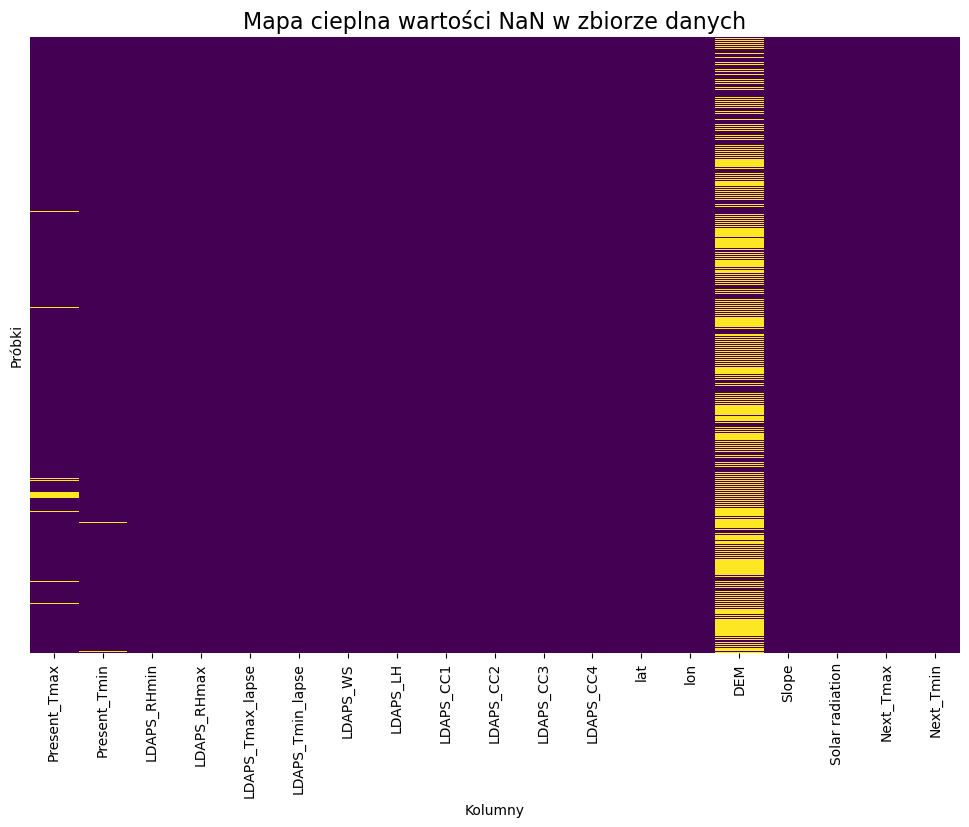

In [10]:
# Tworzenie mapy cieplnej brakujących wartości
plt.figure(figsize=(12, 8))
sns.heatmap(data.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title("Mapa cieplna wartości NaN w zbiorze danych", fontsize=16)
plt.xlabel("Kolumny")
plt.ylabel("Próbki")
plt.show()

In [9]:
# podsumowanie brakujących wartości
missing_summary = (
    data.isnull().sum()
    .to_frame(name='Missing Values')
    .reset_index()
    .rename(columns={'index': 'Column'})
)
missing_summary

,Column,Missing Values
0,Present_Tmax,156
1,Present_Tmin,11
2,LDAPS_RHmin,0
3,LDAPS_RHmax,0
4,LDAPS_Tmax_lapse,0
5,LDAPS_Tmin_lapse,0
6,LDAPS_WS,0
7,LDAPS_LH,0
8,LDAPS_CC1,0
9,LDAPS_CC2,0


In [11]:
data.head()

,Present_Tmax,Present_Tmin,LDAPS_RHmin,LDAPS_RHmax,LDAPS_Tmax_lapse,LDAPS_Tmin_lapse,LDAPS_WS,LDAPS_LH,LDAPS_CC1,LDAPS_CC2,LDAPS_CC3,LDAPS_CC4,lat,lon,DEM,Slope,Solar radiation,Next_Tmax,Next_Tmin
0,28.7,21.4,58.255688,91.116364,28.074101,23.006936,6.818887,69.451805,0.233947,0.203896,0.161697,0.130928,37.6046,126.991,212.335,2.7850,5992.895996,29.1,21.2
1,31.9,21.6,52.263397,90.604721,29.850689,24.035009,5.691890,51.937448,0.225508,0.251771,0.159444,0.127727,37.6046,127.032,NaN,0.5141,5869.312500,30.5,22.5
2,31.6,23.3,48.690479,83.973587,30.091292,24.565633,6.138224,20.573050,0.209344,0.257469,0.204091,0.142125,37.5776,127.058,NaN,0.2661,5863.555664,31.1,23.9
3,32.0,23.4,58.239788,96.483688,29.704629,23.326177,5.650050,65.727144,0.216372,0.226002,0.161157,0.134249,37.6450,127.022,NaN,2.5348,5856.964844,31.7,24.3
4,31.4,21.9,56.174095,90.155128,29.113934,23.486480,5.735004,107.965535,0.151407,0.249995,0.178892,0.170021,37.5507,127.135,NaN,0.5055,5859.552246,31.2,22.5


In [12]:
y=data['Solar radiation']
x=data.drop('Solar radiation',axis=1)
x_train,x_test,y_train,y_test=train_test_split(x,y,train_size=0.7,random_state=42,shuffle=True)

In [13]:
# Imputacja braków metodą wypełniania zerami
imp_zero = SimpleImputer(strategy='constant', fill_value=0)
x_train_imputed = imp_zero.fit_transform(x_train)
x_test_imputed = imp_zero.transform(x_test)

In [14]:
# Skalowanie danych
scaler = StandardScaler()
scaler.fit(x_train_imputed)
# Przekształcenie danych do DataFrame z odpowiednimi nazwami kolumn
x_train_imputed = pd.DataFrame(scaler.transform(x_train_imputed), columns=x_train.columns, index=x_train.index)
x_test_imputed = pd.DataFrame(scaler.transform(x_test_imputed), columns=x_test.columns, index=x_test.index)

In [15]:
models={'Linear Regression':LinearRegression(),
           'Decision Tree':DecisionTreeRegressor(),
           'Random Forest':RandomForestRegressor(n_estimators=100, max_depth=3, random_state=42),
            'Gradient Boosting':GradientBoostingRegressor(random_state=42, n_estimators=100, learning_rate=0.1, max_depth=3)}

In [16]:
# iteracja po każdym modelu
for name, model in models.items():
    # irenowanie modelu na danych treningowych
    model.fit(x_train_imputed, y_train)
    
    # predykcja na zbiorze testowym
    y_pred = model.predict(x_test_imputed)
    
    # obliczanie metryk
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    # wyświetlenie wyników dla aktualnego modelu
    print(f"Model: {name}")
    print("MSE: {:.2f}".format(mse))
    print("MAE: {:.2f}".format(mae))
    print("RMSE: {:.2f}".format(rmse))
    print("R²: {:.2f}".format(r2))
    print("-" * 30)

Model: Linear Regression
MSE: 151018.08
MAE: 327.99
RMSE: 388.61
R²: 0.20
------------------------------
Model: Decision Tree
MSE: 104662.96
MAE: 161.98
RMSE: 323.52
R²: 0.44
------------------------------
Model: Random Forest
MSE: 151909.35
MAE: 326.68
RMSE: 389.76
R²: 0.19
------------------------------
Model: Gradient Boosting
MSE: 99383.09
MAE: 254.62
RMSE: 315.25
R²: 0.47
------------------------------


In [17]:
# Imputacja braków metodą wypełniania medianą
imp_median = SimpleImputer(strategy='median')
x_train_imputed = imp_median.fit_transform(x_train)
x_test_imputed = imp_median.transform(x_test)

In [18]:
# Skalowanie danych
scaler = StandardScaler()
scaler.fit(x_train_imputed)
# Przekształcenie danych do DataFrame z odpowiednimi nazwami kolumn
x_train_imputed = pd.DataFrame(scaler.transform(x_train_imputed), columns=x_train.columns, index=x_train.index)
x_test_imputed = pd.DataFrame(scaler.transform(x_test_imputed), columns=x_test.columns, index=x_test.index)

In [19]:
# iteracja po każdym modelu
for name, model in models.items():
    # irenowanie modelu na danych treningowych
    model.fit(x_train_imputed, y_train)
    
    # predykcja na zbiorze testowym
    y_pred = model.predict(x_test_imputed)
    
    # obliczanie metryk
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    # wyświetlenie wyników dla aktualnego modelu
    print(f"Model: {name}")
    print("MSE: {:.2f}".format(mse))
    print("MAE: {:.2f}".format(mae))
    print("RMSE: {:.2f}".format(rmse))
    print("R²: {:.2f}".format(r2))
    print("-" * 30)

Model: Linear Regression
MSE: 150344.49
MAE: 326.32
RMSE: 387.74
R²: 0.20
------------------------------
Model: Decision Tree
MSE: 107038.72
MAE: 162.45
RMSE: 327.17
R²: 0.43
------------------------------
Model: Random Forest
MSE: 151807.63
MAE: 326.66
RMSE: 389.62
R²: 0.19
------------------------------
Model: Gradient Boosting
MSE: 98674.81
MAE: 254.20
RMSE: 314.13
R²: 0.48
------------------------------


In [20]:
def multiple_imputation_mice(train, test, num_imputations=3):
    train_imputed_datasets = []
    test_imputed_datasets = []

    for i in range(num_imputations):

        mice_imputer = IterativeImputer(random_state=i, max_iter=10, sample_posterior=True)

        # Imputacja dla zbioru treningowego
        imputed_train = pd.DataFrame(mice_imputer.fit_transform(train), columns=train.columns)
        train_imputed_datasets.append(imputed_train)

        # Imputacja dla zbioru testowego
        imputed_test = pd.DataFrame(mice_imputer.transform(test), columns=test.columns)
        test_imputed_datasets.append(imputed_test)

    # agregacja wyników imputacji
    aggregated_train = pd.concat(train_imputed_datasets).groupby(level=0).mean()
    aggregated_test = pd.concat(test_imputed_datasets).groupby(level=0).mean()

    return aggregated_train, aggregated_test

aggregated_train, aggregated_test = multiple_imputation_mice(x_train, x_test, num_imputations=3)

In [21]:
# Skalowanie danych
scaler = StandardScaler()
scaler.fit(aggregated_train)
# Przekształcenie danych do DataFrame z odpowiednimi nazwami kolumn
aggregated_train_scaled = pd.DataFrame(scaler.transform(aggregated_train), columns=aggregated_train.columns, index=aggregated_train.index)
aggregated_test_scaled = pd.DataFrame(scaler.transform(aggregated_test), columns=aggregated_test.columns, index=aggregated_test.index)

In [22]:
# iteracja po każdym modelu
for name, model in models.items():
    # irenowanie modelu na danych treningowych
    model.fit(x_train_imputed, y_train)
    
    # predykcja na zbiorze testowym
    y_pred = model.predict(x_test_imputed)
    
    # obliczanie metryk
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    # wyświetlenie wyników dla aktualnego modelu
    print(f"Model: {name}")
    print("MSE: {:.2f}".format(mse))
    print("MAE: {:.2f}".format(mae))
    print("RMSE: {:.2f}".format(rmse))
    print("R²: {:.2f}".format(r2))
    print("-" * 30)

Model: Linear Regression
MSE: 150344.49
MAE: 326.32
RMSE: 387.74
R²: 0.20
------------------------------
Model: Decision Tree
MSE: 107615.20
MAE: 164.33
RMSE: 328.05
R²: 0.43
------------------------------
Model: Random Forest
MSE: 151807.63
MAE: 326.66
RMSE: 389.62
R²: 0.19
------------------------------
Model: Gradient Boosting
MSE: 98674.81
MAE: 254.20
RMSE: 314.13
R²: 0.48
------------------------------


In [23]:
# Imputacja braków metodą wypełniania knn
imp_knn = KNNImputer(n_neighbors=3)
x_train_imputed = imp_knn.fit_transform(x_train)
x_test_imputed = imp_knn.transform(x_test)

In [24]:
# Skalowanie danych
scaler = StandardScaler()
scaler.fit(x_train_imputed)
# Przekształcenie danych do DataFrame z odpowiednimi nazwami kolumn
x_train_imputed = pd.DataFrame(scaler.transform(x_train_imputed), columns=x_train.columns, index=x_train.index)
x_test_imputed = pd.DataFrame(scaler.transform(x_test_imputed), columns=x_test.columns, index=x_test.index)

In [25]:
# iteracja po każdym modelu
for name, model in models.items():
    # irenowanie modelu na danych treningowych
    model.fit(x_train_imputed, y_train)
    
    # predykcja na zbiorze testowym
    y_pred = model.predict(x_test_imputed)
    
    # obliczanie metryk
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    # wyświetlenie wyników dla aktualnego modelu
    print(f"Model: {name}")
    print("MSE: {:.2f}".format(mse))
    print("MAE: {:.2f}".format(mae))
    print("RMSE: {:.2f}".format(rmse))
    print("R²: {:.2f}".format(r2))
    print("-" * 30)

Model: Linear Regression
MSE: 150672.01
MAE: 326.48
RMSE: 388.16
R²: 0.20
------------------------------
Model: Decision Tree
MSE: 105289.50
MAE: 162.12
RMSE: 324.48
R²: 0.44
------------------------------
Model: Random Forest
MSE: 151745.82
MAE: 326.47
RMSE: 389.55
R²: 0.20
------------------------------
Model: Gradient Boosting
MSE: 97976.27
MAE: 253.86
RMSE: 313.01
R²: 0.48
------------------------------


In [26]:
# Funkcja imputacji LightGBM
def lightgbm_imputation_train_test(x_train, x_test):
    x_train = x_train.copy()
    x_test = x_test.copy()
    
    for column in x_train.columns:
        missing_train = x_train[column].isnull()
        missing_test = x_test[column].isnull()
        
        if missing_train.any() or missing_test.any():
            # Przygotowanie danych do modelu
            x_train_features = x_train.loc[~missing_train].drop(columns=column)
            y_train = x_train.loc[~missing_train, column]
            
            x_test_features = x_test.drop(columns=column)
            
            # LightGBM - imputacja na zbiorze treningowym
            model = LGBMRegressor(random_state=42)
            model.fit(x_train_features, y_train)
            
            # Imputacja braków w zbiorze treningowym
            if missing_train.any():
                x_train.loc[missing_train, column] = model.predict(x_train.loc[missing_train].drop(columns=column))
            
            # Imputacja braków w zbiorze testowym
            if missing_test.any():
                x_test.loc[missing_test, column] = model.predict(x_test_features.loc[missing_test])
    
    return x_train, x_test

x_train_imputed, x_test_imputed = lightgbm_imputation_train_test(x_train, x_test)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000323 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3048
[LightGBM] [Info] Number of data points in the train set: 5194, number of used features: 17
[LightGBM] [Info] Start training from score 29.652715
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000331 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3120
[LightGBM] [Info] Number of data points in the train set: 5301, number of used features: 17
[LightGBM] [Info] Start training from score 23.230975
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000304 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3130
[LightGBM] [Info] Number of data points in the train set: 2559, number of used features: 17
[LightGBM] [Info] Start trai

In [27]:
# Skalowanie danych
scaler = StandardScaler()
scaler.fit(x_train_imputed)
# Przekształcenie danych do DataFrame z odpowiednimi nazwami kolumn
x_train_imputed = pd.DataFrame(scaler.transform(x_train_imputed), columns=x_train.columns, index=x_train.index)
x_test_imputed = pd.DataFrame(scaler.transform(x_test_imputed), columns=x_test.columns, index=x_test.index)

In [28]:
# iteracja po każdym modelu
for name, model in models.items():
    # irenowanie modelu na danych treningowych
    model.fit(x_train_imputed, y_train)
    
    # predykcja na zbiorze testowym
    y_pred = model.predict(x_test_imputed)
    
    # obliczanie metryk
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    # wyświetlenie wyników dla aktualnego modelu
    print(f"Model: {name}")
    print("MSE: {:.2f}".format(mse))
    print("MAE: {:.2f}".format(mae))
    print("RMSE: {:.2f}".format(rmse))
    print("R²: {:.2f}".format(r2))
    print("-" * 30)

Model: Linear Regression
MSE: 151007.38
MAE: 327.04
RMSE: 388.60
R²: 0.20
------------------------------
Model: Decision Tree
MSE: 105019.90
MAE: 160.98
RMSE: 324.07
R²: 0.44
------------------------------
Model: Random Forest
MSE: 151945.26
MAE: 326.68
RMSE: 389.80
R²: 0.19
------------------------------
Model: Gradient Boosting
MSE: 98436.53
MAE: 254.11
RMSE: 313.75
R²: 0.48
------------------------------


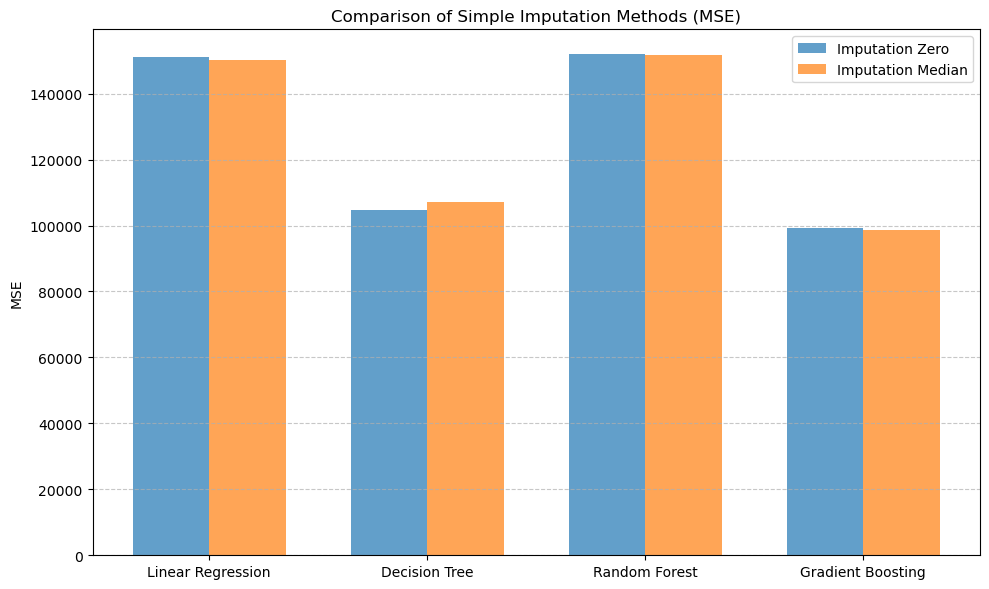

In [30]:
import matplotlib.pyplot as plt
import numpy as np
methods = ['Imputacja zerem', 'Imputacja mediana']
models = ['Linear Regression', 'Decision Tree', 'Random Forest', 'Gradient Boosting']
mse_zero = [151018.08,
104662.96,
151909.35,
99383.09
]
mse_median = [150344.49,
107038.72,
151807.63,
98674.81
]
x = np.arange(len(models)) 
width = 0.35  
plt.figure(figsize=(10, 6))
plt.bar(x - width/2, mse_zero, width, label='Imputation Zero', alpha=0.7)
plt.bar(x + width/2, mse_median, width, label='Imputation Median', alpha=0.7)
plt.ylabel('MSE')
plt.title('Comparison of Simple Imputation Methods (MSE)')
plt.xticks(x, models)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

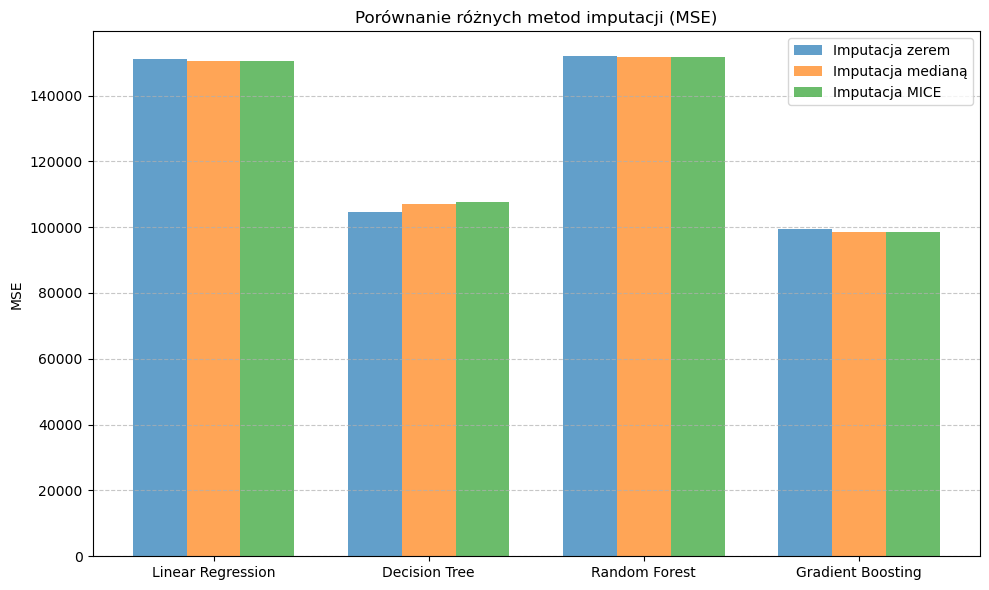

In [31]:
import matplotlib.pyplot as plt
import numpy as np
models = ['Linear Regression', 'Decision Tree', 'Random Forest', 'Gradient Boosting']
mse_zero = [151018.08,
104662.96,
151909.35,
99383.09
]
mse_median = [150344.49,
107038.72,
151807.63,
98674.81
]
mse_mice = [150344.49,
107615.20,
151807.63,
98674.81
]
x = np.arange(len(models)) 
width = 0.25               
plt.figure(figsize=(10, 6))
plt.bar(x - width, mse_zero, width, label='Imputacja zerem', alpha=0.7)
plt.bar(x, mse_median, width, label='Imputacja medianą', alpha=0.7)
plt.bar(x + width, mse_mice, width, label='Imputacja MICE', alpha=0.7)
plt.ylabel('MSE')
plt.title('Porównanie różnych metod imputacji (MSE)')
plt.xticks(x, models)  # x określa pozycje, a `models` - etykiety
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")
data = {
    "method": [
        "zero", "zero", "zero", "zero",
        "mediana", "mediana", "mediana", "mediana",
        "MICE", "MICE", "MICE", "MICE",
        "KNN", "KNN", "KNN", "KNN",
        "LightGBM", "LightGBM", "LightGBM", "LightGBM"
    ],
    "model": [
        "LR", "DT", "RF", "GB",
        "LR", "DT", "RF", "GB",
        "LR", "DT", "RF", "GB",
        "LR", "DT", "RF", "GB",
        "LR", "DT", "RF", "GB"
    ],
    "R2": [
        # zero
        0.20, 0.44, 0.19, 0.47,
        # mediana
        0.20, 0.43, 0.19, 0.48,
        # MICE
        0.20, 0.43, 0.19, 0.48,
        # KNN
        0.20, 0.44, 0.20, 0.48,
        # LightGBM
        0.20, 0.44, 0.19, 0.48
    ],
    "MSE": [
        # zero
        151018.08, 104662.96, 151909.35, 99383.09,
        # mediana
        150344.49, 107038.72, 151807.63, 98674.81,
        # MICE
        150344.49, 107615.20, 151807.63, 98674.81,
        # KNN
        150672.01, 105289.50, 151745.82, 97979.27,
        # LightGBM
        151007.38, 105019.90, 151945.26, 98436.53
    ]
}
df = pd.DataFrame(data)
print(df)

      method model    R2        MSE
0       zero    LR  0.20  151018.08
1       zero    DT  0.44  104662.96
2       zero    RF  0.19  151909.35
3       zero    GB  0.47   99383.09
4    mediana    LR  0.20  150344.49
5    mediana    DT  0.43  107038.72
6    mediana    RF  0.19  151807.63
7    mediana    GB  0.48   98674.81
8       MICE    LR  0.20  150344.49
9       MICE    DT  0.43  107615.20
10      MICE    RF  0.19  151807.63
11      MICE    GB  0.48   98674.81
12       KNN    LR  0.20  150672.01
13       KNN    DT  0.44  105289.50
14       KNN    RF  0.20  151745.82
15       KNN    GB  0.48   97979.27
16  LightGBM    LR  0.20  151007.38
17  LightGBM    DT  0.44  105019.90
18  LightGBM    RF  0.19  151945.26
19  LightGBM    GB  0.48   98436.53


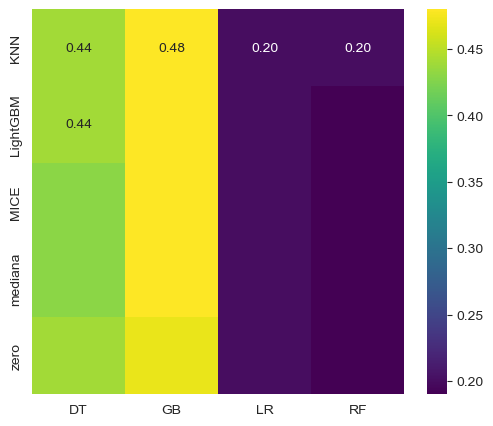

In [34]:
df_pivot_r2 = df.pivot(index="method", columns="model", values="R2")
plt.figure(figsize=(6, 5))
sns.heatmap(df_pivot_r2, annot=True, cmap="viridis", fmt=".2f")
plt.title("")
plt.xlabel("")
plt.ylabel("")
plt.show()

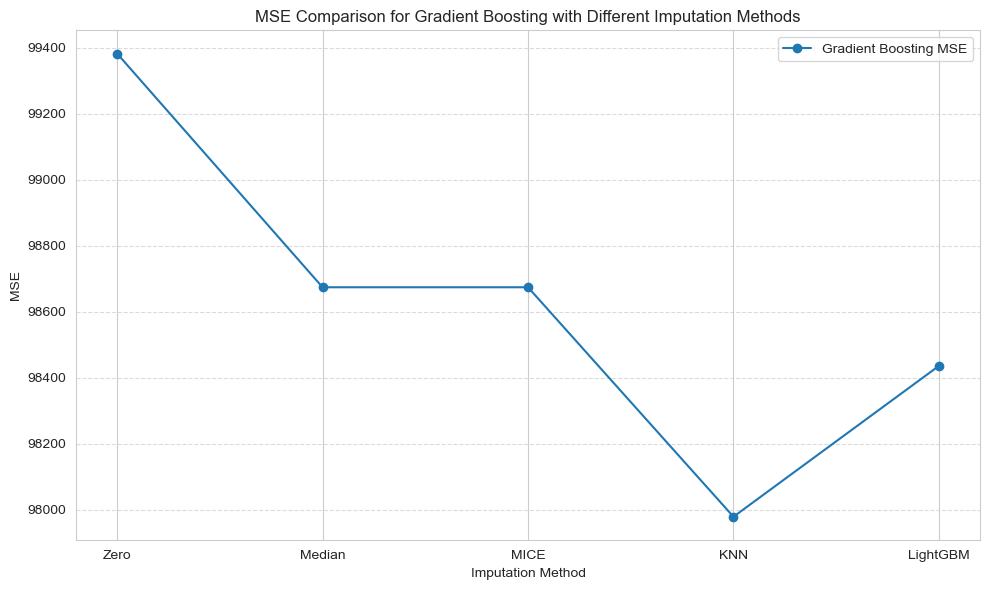

In [3]:
mse_methods = [99383.09, 98674.81, 98674.81, 97979.27, 98436.53]
methods = ['Zero', 'Median', 'MICE', 'KNN', 'LightGBM']
# Stworzenie wykresu liniowego
plt.figure(figsize=(10, 6))
plt.plot(methods, mse_methods, marker='o', linestyle='-', label='Gradient Boosting MSE')
plt.ylabel('MSE')
plt.xlabel('Imputation Method')
plt.title('MSE Comparison for Gradient Boosting with Different Imputation Methods')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()